In [109]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
img_size = 64
hidden_dim = 512
latent_dim = 512
class Encoder(nn.Module):
    def __init__(self, x_dim=img_size**2, h_dim=hidden_dim, z_dim=latent_dim):
        super(Encoder, self).__init__()

        # 1st hidden layer
        self.fc1 = nn.Sequential(
            nn.Linear(x_dim, h_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2)
        )

        # 2nd hidden layer
        self.fc2 = nn.Sequential(
            nn.Linear(h_dim, h_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2)
        )

        # output layer
        self.mu = nn.Linear(h_dim, z_dim)
        self.logvar = nn.Linear(h_dim, z_dim)

    def forward(self, x):
        x = self.fc2(self.fc1(x))

        mu = F.relu(self.mu(x))
        logvar = F.relu(self.logvar(x))

        z = reparameterization(mu, logvar)
        return z, mu, logvar

In [110]:
def reparameterization(mu, logvar):
    std = torch.exp(logvar/2)
    eps = torch.randn_like(std)
    return mu + eps * std

In [111]:
class Decoder(nn.Module):
    def __init__(self, x_dim=img_size**2, h_dim=hidden_dim, z_dim=latent_dim):
        super(Decoder, self).__init__()

        # 1st hidden layer
        self.fc1 = nn.Sequential(
            nn.Linear(z_dim, h_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2),
        )

        # 2nd hidden layer
        self.fc2 = nn.Sequential(
            nn.Linear(h_dim, h_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2)
        )

        # output layer
        self.fc3 = nn.Linear(h_dim, x_dim)

    def forward(self, z):
        z = self.fc2(self.fc1(z))
        x_reconst = F.sigmoid(self.fc3(z))
        return x_reconst

In [112]:
import logging

import matplotlib.pyplot as plt
from numpy.random import RandomState

from sklearn import cluster, decomposition
from sklearn.datasets import fetch_olivetti_faces

rng = RandomState(0)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")

faces, targets = fetch_olivetti_faces(return_X_y=True, shuffle=True, random_state=rng)
n_samples, n_features = faces.shape

# Global centering (focus on one feature, centering all samples)
faces_centered = faces - faces.mean(axis=0)

# Local centering (focus on one sample, centering all features)
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

print("Dataset consists of %d faces" % n_samples)
faces.shape,targets.shape

Dataset consists of 400 faces


((400, 4096), (400,))

In [113]:
train = faces[:300]
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 50
learning_rate = 0.0001
epoch_num = 15


In [114]:
n_epochs = 20
batch_size = 128
train_dataloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True,)
encoder = Encoder().to(device)
decoder = Decoder().to(device)
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)



In [115]:

logger = {}
logger['train_loss'] = []
logger['test_loss'] = []
logger['kl_div'] = []
for epoch in range(n_epochs):
    for i, x in enumerate(train_dataloader):
        # forward
        x = x.view(-1, img_size**2)
        x = x.to(device)
        z, mu, logvar = encoder(x)
        x_reconst = decoder(z)

        # compute reconstruction loss and KL divergence
        reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
        kl_div = 0.5 * torch.sum(mu.pow(2) + logvar.exp() - logvar - 1)

        # backprop and optimize
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('Epoch [{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}'.format(epoch+1, n_epochs, i+1, len(train_dataloader), reconst_loss.item(), kl_div.item()))
    logger['train_loss'].append(loss.item())
    logger['test_loss'].append(loss.item())
    logger['kl_div'].append(kl_div.item())
        
        

Epoch [1/20], Step [3/3], Reconst Loss: 125022.2969, KL Div: 13.0950
Epoch [2/20], Step [3/3], Reconst Loss: 124795.4922, KL Div: 7.9590
Epoch [3/20], Step [3/3], Reconst Loss: 124605.9297, KL Div: 5.9907
Epoch [4/20], Step [3/3], Reconst Loss: 124375.4062, KL Div: 5.1526
Epoch [5/20], Step [3/3], Reconst Loss: 123905.7422, KL Div: 4.6511
Epoch [6/20], Step [3/3], Reconst Loss: 123920.1562, KL Div: 4.5927
Epoch [7/20], Step [3/3], Reconst Loss: 123685.2656, KL Div: 4.9223
Epoch [8/20], Step [3/3], Reconst Loss: 122819.2031, KL Div: 5.6076
Epoch [9/20], Step [3/3], Reconst Loss: 122674.7500, KL Div: 7.2865
Epoch [10/20], Step [3/3], Reconst Loss: 122388.0312, KL Div: 10.4397
Epoch [11/20], Step [3/3], Reconst Loss: 122209.5625, KL Div: 13.6779
Epoch [12/20], Step [3/3], Reconst Loss: 121653.6797, KL Div: 13.1445
Epoch [13/20], Step [3/3], Reconst Loss: 121953.4844, KL Div: 10.1086
Epoch [14/20], Step [3/3], Reconst Loss: 121050.4219, KL Div: 5.7836
Epoch [15/20], Step [3/3], Reconst Los

(1, 512)
torch.Size([1, 4096])
(1, 512)
torch.Size([1, 4096])
(1, 512)
torch.Size([1, 4096])
(1, 512)
torch.Size([1, 4096])
(1, 512)
torch.Size([1, 4096])
(1, 512)
torch.Size([1, 4096])


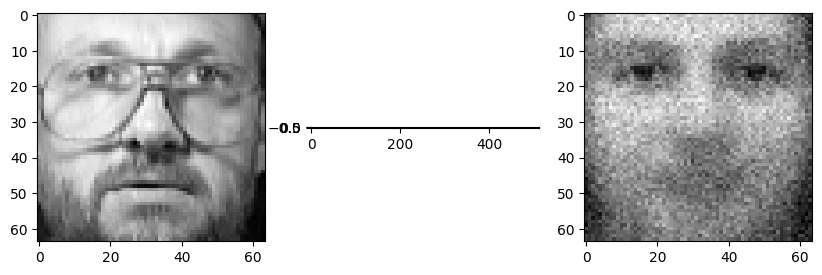

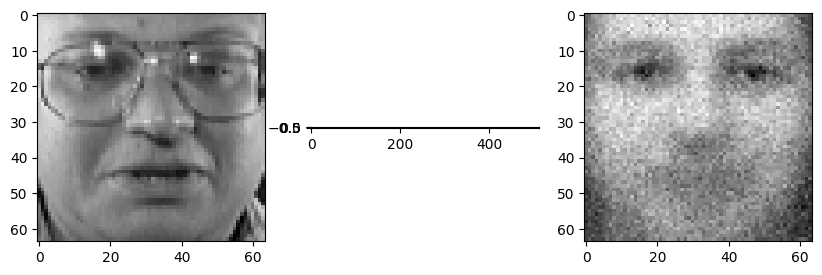

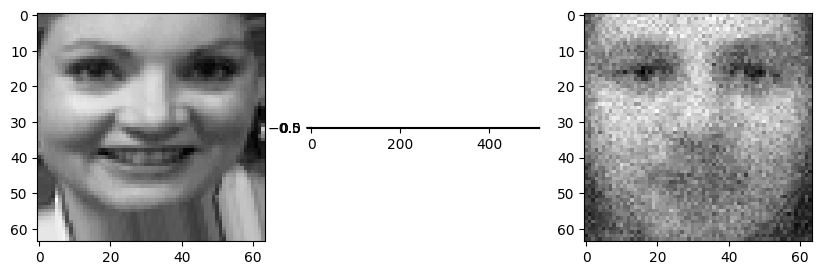

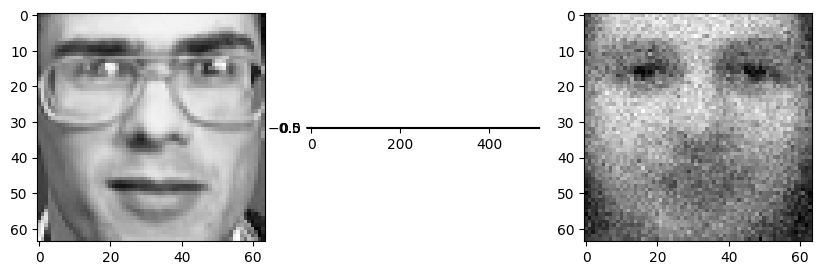

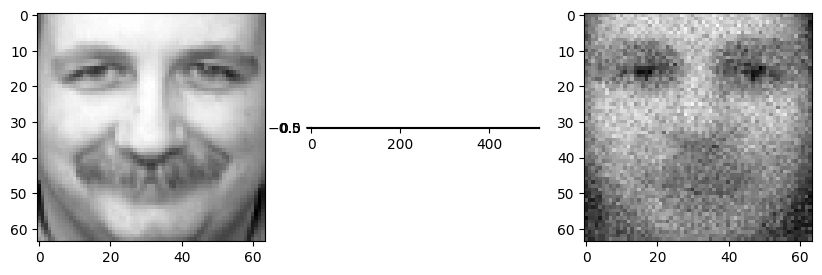

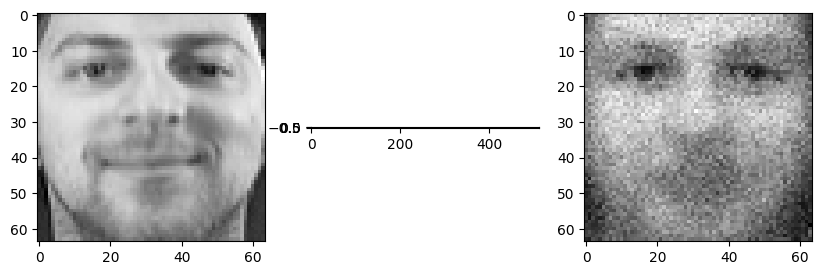

In [116]:
for i in range(0,6):
    x = faces[0].reshape(-1, img_size**2)
    x = torch.from_numpy(x).float()
    x = x.to(device)

    z,a,b = encoder(x)
    g = decoder(z)

    z = z.cpu().detach().numpy()
    print(z.shape)

    # g = decoder(z)

    
    print(g.shape)
    g = g.cpu().detach().numpy().reshape(64,64)
    plt.figure(figsize=(10,5))
    plt.subplot(1,3,1)
    plt.imshow(train[i].reshape(64,64),cmap='gray')
    plt.subplot(1,3,2)
    plt.imshow(z,cmap='gray',vmin=-1,vmax=1)
    plt.subplot(1,3,3)
    plt.imshow(g,cmap='gray')

In [117]:
zs = []
for i in range(0,3000):
    x = train[i][0].view(-1, img_size**2)
    x = x.to(device)

    z,a,b = encoder(x)
    g = decoder(z)

    z = z.cpu().detach().numpy()
    zs.append(z)
type(zs[0])

zs = np.array(zs)
zs = zs.reshape(3000,latent_dim)
zs.shape

ValueError: Type must be a sub-type of ndarray type

In [ ]:
import re, seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D


import numpy as np

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

# generate data
x = zs[:,0]
y = zs[:,1]
z = zs[:,2]
# change the label to int
label = train.targets[:3000].numpy()

# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# plot
sc = ax.scatter(x, y, z, s=40, c=label, marker='o', cmap=cmap, alpha=1)
ax.set_xlabel('latent dim 1')
ax.set_ylabel('latent dim 2')
ax.set_zlabel('latent dim 3')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# save
plt.savefig("scatter_hue", bbox_inches='tight')

from matplotlib import animation

def rotate(angle):
    ax.view_init(azim=angle)

angle = 3
ani = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 360, angle), interval=10)
ani.save('vae_3point.gif', writer=animation.PillowWriter(fps=60))